In [250]:
import pandas as pd
import sys
import os
import re
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import re, unicodedata
from typing import List, Dict, Optional



In [251]:
#paths to the data

ds = "Merging/experiment-data-2025-11-13"

csv_files = [f for f in os.listdir(ds) if f.endswith(".csv")]

count = len(csv_files)
print("Number of CSV files in experiment-data-2025-11-08:", count)

ouput_path="Merging/Results"


Number of CSV files in experiment-data-2025-11-08: 1975


## Filtering after Date

In [252]:
import re

def _contains(s: str, *aliases: str) -> bool:
    s = s.lower()
    return any(a.lower() in s for a in aliases)

# Cutoff-Datum, ab wann Studien gültig sind
DEFAULT_CUTOFF = "20250828_140600"

# Pattern der Dateinamen, z.B. 20250828_161852_Survey_23_Warenkorb_VIP.csv
PATTERN = re.compile(
    r"^\d{8}_\d{6}_Survey_\d+",
    re.IGNORECASE
)

# gültig = passt zum Pattern UND enthält kein "test"
def is_valid_pattern(fn: str) -> bool:
    return bool(PATTERN.match(fn)) and not _contains(fn, "test")


filtered = []
counter = 0

too_old_files = []          # wegen Cutoff-Datum entfernt
invalid_pattern_files = []  # wegen Pattern/"test" entfernt

for fn in csv_files:
    counter += 1
    file_date = fn[:15]   # 'YYYYMMDD_HHMMSS'

    # 1️⃣ Priorität: Cutoff-Datum
    if file_date < DEFAULT_CUTOFF:
        too_old_files.append(fn)
        continue

    # 2️⃣ Danach: Pattern / "test"
    if not is_valid_pattern(fn):
        invalid_pattern_files.append(fn)
        continue

    # 3️⃣ Nur diese werden behalten
    filtered.append(fn)

csv_files = filtered.copy()

print("===== Filter-Report =====")
print(f"Gesamtanzahl Dateien: {counter}")
print(f"Behalten nach Cutoff + Pattern: {len(filtered)}")

print(f"\nHerausgefiltert wegen Cutoff-Datum (< {DEFAULT_CUTOFF}): {len(too_old_files)}")
if too_old_files:
    print("  Diese Dateien waren zu alt:")
    for fn in too_old_files:
        print("   -", fn)

print(f"\nHerausgefiltert wegen ungültigem Pattern / 'test': {len(invalid_pattern_files)}")
if invalid_pattern_files:
    print("  Diese Dateien hatten ein ungültiges Pattern oder 'test' im Namen:")
    for fn in invalid_pattern_files:
        print("   -", fn)

print("\nNumber of kept files after cutoff & pattern:", len(filtered))


===== Filter-Report =====
Gesamtanzahl Dateien: 1975
Behalten nach Cutoff + Pattern: 1832

Herausgefiltert wegen Cutoff-Datum (< 20250828_140600): 142
  Diese Dateien waren zu alt:
   - 20250826_140752_Survey_21_BeachBar_TrashCollectionDonationTime-sirk.csv
   - 20250823_210608_Survey_28_Donation_SpendentafelMoney-uwah.csv
   - 20250826_171311_Survey_28_Donation_Money-n9ok.csv
   - 20250823_213459_Survey_21_CollectingTrash_NoVideo-v2td.csv
   - 20250827_191229_Survey_28_Mall_Donation_Awe_Money_abc123.csv
   - 20250821_143510_Survey_28_Donation_SpendentafelTime-0nvc.csv
   - 20250828_121239_Survey_23_Warenkorb_HippieGlamE-IUQK35.csv
   - 20250824_191902_Survey_23_Warenkorb_GlamM-x2dl.csv
   - 20250824_003811_Survey_23_Warenkorb_VideoAweNeutralM-yajo.csv
   - 20250824_195758_Survey_21_BeachBar_TrashCollectionDonationSpendentafelTime-txq8.csv
   - 20250824_173648_Survey_21_BeachBar_TrashCollectionDonationSpendentafelTime-g7dy.csv
   - 20250828_120202_Survey_23_Warenkorb_HippieGlamE_MuP-T8

## Create Master CSV

### Encode Experiments

In [253]:
csv_files.sort()


def read_csv_robust(path):
    attempts = [
        dict(),
        dict(engine="python"),
        dict(engine="python", on_bad_lines="skip"),
        dict(engine="python", sep=None, on_bad_lines="skip"),
    ]

    for opts in attempts:
        try:
            return pd.read_csv(path, **opts)
        except Exception:
            continue

    raise RuntimeError(f"Cannot read CSV: {path}")


# ---------- Experiment code parsing from filename ----------


def parse_experiment_code(filename) -> str:
    """Return compact code like BB_T_D_M, M_D_S_T, W_VN_H, etc."""
    low = filename.lower()

    # BeachBar
    if _contains(low, "beachbar"):
        # always Trash and Donation
        # Moderator: Public/Private
        visibility = "S" if _contains(low, "spendentafel") else None
        donationType = "M" if _contains(low, "money") else ("T" if _contains(low, "time") else None)
        if visibility and donationType:
            #moderator condition
            #BB_T_D_SM
            #BB_T_D_ST
            return f"BB_T_D_{visibility}{donationType}"
        if donationType:
            #no moderator
            #BB_T_D_T
            #BB_T_D_M
            return f"BB_T_D_{donationType}"
        
        return "BB_T_D"

    # Mall
    # ==== Mall family ====
    if _contains(low, "mall"):

    #DV: Donation: Donation experiments
        if _contains(low, "donation"):

            #Visibility OR Video as Moderator

            # Visibility: Spendentafel vs none
            visibility = "S" if _contains(low, "spendentafel") else None

            # Video: Awe / Neutral / None
            videoType = None
            if _contains(low, "awe"):
                videoType = "A"
            elif _contains(low, "neutral"):
                videoType = "N"

            #DV: Donation Amount, either Money or Time

            # Donation type: Money / Time
            donationType = None
            if _contains(low, "money"):
                donationType = "M"
            elif _contains(low, "time"):
                donationType = "T"

            # visibility OR videotype OR none + donation Type
            if visibility and donationType:
                # M_D_S_M / M_D_S_T
                return f"M_D_{visibility}_{donationType}"
            if videoType and donationType:
                # M_D_A_M / M_D_A_T / M_D_N_M / M_D_N_T
                return f"M_D_{videoType}_{donationType}"
            if donationType:
                # M_D_M / M_D_T
                return f"M_D_{donationType}"
            # Fallback 
            return "UNKNOWN_MALL_DONATION"

    #DV: TRASH: Trash experiments
    #only video as moderator
    if _contains(low, "trash"):
        if _contains(low, "novideo"):
            return f"M_T_NV"   # M_T_NV
        if _contains(low, "awe"):
            return f"M_T_A"    # M_T_A
        if _contains(low, "neutral"):
            return f"M_T_N"    # M_T_N
        return f"UNKNOWN_MALL_TRASH"


    # Warenkorb
    if _contains(low, "warenkorb"):
        # cross-style first
        if "glamhippiee" in low: return "W_GHE"
        if "hippieglame" in low: return "W_HGE"


        #moderator: VIP treatment
        vip = None
        #check for longer string first, then elif no overlap
        if _contains(low, "nonvip"): vip = "NV"
        elif _contains(low, "vip"):                    vip = "V"

        videoType = "VA" if _contains(low, "videoawe") else ("VN" if _contains(low, "videoneutral") else None)

        warenkorbStyle = None

        if _contains(low, "hippieglam"):
            warenkorbStyle = "hippieglame"
        elif _contains(low, "glamhippie"):
            warenkorbStyle = "glamhippiee"
        elif _contains(low, "glam"):
            warenkorbStyle = "G"
        elif _contains(low, "hippiem"):
            warenkorbStyle = "H"
        elif _contains(low, "neutralm"):
            warenkorbStyle = "N"
        elif _contains(low, "neutral") and not _contains(low, "videoneutral"):
            warenkorbStyle = "N"
        else:
            warenkorbStyle = None


        if videoType and warenkorbStyle: return f"W_{videoType}_{warenkorbStyle}"
        #W_VA_H
        #W_VA_N
        #W_VN_H
        #W_VN_N

        
        if vip and warenkorbStyle:   return f"W_{vip}_{warenkorbStyle}"
        #W_NV_G
        #/W_NV_N
        #W_V_G
        #W_V_N

        if warenkorbStyle:           return f"W_{warenkorbStyle}"
        #W_G
        #W_H
        #W_n
        return "W_UNKNOWN"


# ---------- Condition decoding from experiment code ----------
def decode_conditions(code: str) -> Dict[str, Optional[str]]:
    """Atomic condition columns derived from the compact code."""
    info: Dict[str, Optional[str]] = {
        "Experiment_Type": code,
        "Store": None,             # BeachBar or Mall
        "Donation_Type": None,     # Money | Time | None
        "VideoType": None,         # Awe | Neutral | NoVideo | None
        "Visibility": None,        # Public | Private | None
        "VIP_Treatment": None,     # VIP | NonVIP | None
        "WarenkorbType": None,     # Neutral | Glam | Hippie | Mix
    }

    if code.startswith("BB_"):
        info["Store"] = "BeachBar"
        # donation subconditions
        if code.endswith("_SM"):
            info["Donation_Type"] = "Money"
            info["Visibility"] = "Public"   # Spendentafel
        elif code.endswith("_ST"):
            info["Donation_Type"] = "Time"
            info["Visibility"] = "Public"
        elif code.endswith("_M"):
            info["Donation_Type"] = "Money"
            info["Visibility"] = "Private"
        elif code.endswith("_T"):
            info["Donation_Type"] = "Time"
            info["Visibility"] = "Private"

    elif code.startswith("M_"):
        info["Store"] = "Mall"
        if code.startswith("M_D"):
            # donation arm
            if "_A_" in code: info["VideoType"] = "Awe"
            if "_N_" in code: info["VideoType"] = "Neutral"
            if "_S_" in code: info["Visibility"] = "Public"
            if code.endswith("_M"): info["Donation_Type"] = "Money"
            if code.endswith("_T"): info["Donation_Type"] = "Time"
        elif code.startswith("M_T"):
            # trash arm
            if code.endswith("_A"):   info["VideoType"] = "Awe"
            if code.endswith("_N"):   info["VideoType"] = "Neutral"
            if code.endswith("_NV"):  info["VideoType"] = "NoVideo"

    elif code.startswith("W_"):
        info["Store"] = "Warenkorb"
        # VIP
        if code.startswith("W_V_"):  info["VIP_Treatment"] = "VIP"
        if code.startswith("W_NV_"): info["VIP_Treatment"] = "NonVIP"
        # Video
        if code.startswith("W_VA_"): info["VideoType"] = "Awe"
        if code.startswith("W_VN_"): info["VideoType"] = "Neutral"
        # Product set
        if code.endswith("_G"):      info["WarenkorbType"] = "Glam"
        elif code.endswith("_H"):    info["WarenkorbType"] = "Hippie"
        elif code.endswith("_N"):    info["WarenkorbType"] = "Neutral"
        elif code.endswith("_GHE") or code.endswith("_HGE"):
            info["WarenkorbType"] = "Mix"
            # TODO: if you want subtypes, set to "GlamMix" for W_GHE and "HippieMix" for W_HGE.

    return info

# ---------- Merge keeping per-file column order ----------


### Cleaning and Merging

In [254]:
import os
from typing import List, Dict
import pandas as pd

# --- 1) normalize + aliasing to make names consistent ---
ALIASES: Dict[str, str] = {
    # common trims/variants → canonical
    " IchFindeOutfitSchon": "IchFindeOutfitSchon",
    "StilDesOutfitsGefalltMir ": "StilDesOutfitsGefalltMir",
    "TotalTimeExperiment ": "TotalTimeExperiment",
    "sID ": "sID",
    # add more if you spot them
}

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    # strip whitespace and collapse inner spaces; apply alias corrections
    cols = (
        pd.Series(df.columns)
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .map(lambda c: ALIASES.get(c, c))
    )
    df = df.copy()
    df.columns = cols
    return df

# --- 2) your exact order (with commas fixed) ---
DESIRED_ORDER: List[str] = [
    # atomic meta
    "Experiment_Type","source_file","Store","Donation_Type","VideoType","Visibility","VIP_Treatment","WarenkorbType",
    # common meta
    "Experiment","sID","Timestamp","MatrikelNummer","Gender","Name","Style","HairColor","SkinTone","AssignedAvatar",

    # outcomes
    "totalSpent","numberOfProducts","DonationMoney","DonationTime","trashCount","TotalTimeTrash",

    # associations
    "SelbssicherUnsicher","MutigAngstlich","AuffaligUnauffalig","ManipulativAufrichtig","MachtigMachtlos",
    "ExclusivDurchschnitt","begehrenswertNicht","BewundertNicht","PrivilegiertNicht","WohlhabendNicht","UberheblichDezent",
    "IntelligentSchlicht","EigennutzigUneigen","VerschwenderischSpar","MaterialistischIdealistisch","SpirituellNicht",
    "NaturverbundenNaturfern","AuthentischKunstlich","EmpathischGefuhlskalt","RomantischNicht","FriedlichAggressiv","FreundlichUnfreundlich",

    # scales
    "Scale_SocialStatus_1","Scale_SocialStatus_2","Scale_SocialStatus_3","Scale_SocialStatus_4","Scale_SocialStatus_5","Scale_SocialStatus_6","Scale_SocialStatus_7",
    "Scale_EnvironmentalConcern_1","Scale_EnvironmentalConcern_2","Scale_EnvironmentalConcern_3","Scale_EnvironmentalConcern_4",
    "Scale_Materialism_1","Scale_Materialism_2","Scale_Materialism_3","Scale_Materialism_4",
    "Scale_GreenValueScale_1","Scale_GreenValueScale_2","Scale_GreenValueScale_3","Scale_GreenValueScale_4","Scale_GreenValueScale_5","Scale_GreenValueScale_6",
    "Scale_SocialConfidence_1","Scale_SocialConfidence_2","Scale_SocialConfidence_3","Scale_SocialConfidence_4","Scale_SocialConfidence_5",
    "Scale_Differentiation_1","Scale_Differentiation_2","Scale_Differentiation_3",
    "Scale_Altruism_1","Scale_Altruism_2","Scale_Altruism_3","Scale_Altruism_4",
    "Scale_Empathy_1","Scale_Empathy_2","Scale_Empathy_3","Scale_Empathy_4",
    "Scale_Egoism_1","Scale_Egoism_2","Scale_Egoism_3","Scale_Egoism_4","Scale_Egoism_5","Scale_Egoism_6",

    # items + prices
    "Schlafmaske","price_Schlafmaske","Spiegel","price_Spiegel","Portemonnaie","price_Portemonnaie",
    "Poster","price_Poster","Powerbank","price_Powerbank","Rucksack","price_Rucksack",
    "PS 5","price_PS 5","Gaming Controller","price_Gaming Controller","Seifenstuck","price_Seifenstuck",
    "Wasserflasche","price_Wasserflasche","USB-Stick 256 GB","price_USB-Stick 256 GB","Notizbuch","price_Notizbuch",
    "Reisepasshulle","price_Reisepasshulle","Vase","price_Vase","Trinkflasche 1.2L","price_Trinkflasche 1.2L",
    "Spiral Notizbuch","price_Spiral Notizbuch","Kaffeebereiter","price_Kaffeebereiter","Kaffeetasse","price_Kaffeetasse",
    "T-Shirt","price_T-Shirt","Tragetasche","price_Tragetasche","Schmuckkastchen","price_Schmuckkastchen",
    "Parfum","price_Parfum","Wanduhr","price_Wanduhr","Kissen","price_Kissen","Ventilator","price_Ventilator",
    "Kissen 2","price_Kissen 2","Decke","price_Decke","Tucherbox","price_Tucherbox","Duftstabchen","price_Duftstabchen",
    "Kartenhalter","price_Kartenhalter",

    # context
    "greeting","AcceptedChampagne",

    # attention / manipulation checks
    "KlickenSieDie4An","WieWirktOutfitAufSieUneinheitlichEinheitlich","WieWirktOutfitAufSieHarmonischUnharmonisch",
    "StilDesOutfitsPasstZuMir","IdentifikationMitStilDesOutfits","OutfitWecktAssoziationenDieZuMirPassen",
    "OutfitSprichtMichAn","IchFindeOutfitSchon","StilDesOutfitsGefalltMir",
    "StilPasstZuHipHop","StilPasstZuPunkRockMetal","StilPasstZuHippieBohoFestival","StilPasstZuGlam",
    "WieSchwerInDiesemOutfitVorzustellen",

    # socio / timing
    "GeldProMonat","GeldProMonatKleidung","DeutschkenntnisseGutSchlecht","PolitischeEinstellung1Links11Rechts",
    "Age","TotalTimeExperiment",
]

def apply_order(df: pd.DataFrame) -> pd.DataFrame:
    df = normalize_cols(df)
    present = [c for c in DESIRED_ORDER if c in df.columns]
    extras  = [c for c in df.columns if c not in DESIRED_ORDER]
    # helpful logs
    missing = [c for c in DESIRED_ORDER if c not in df.columns]
    if missing:
        print(f"[WARN] {len(missing)} expected columns absent. First few: {missing[:8]}{' ...' if len(missing)>8 else ''}")
    if extras:
        print(f"[INFO] {len(extras)} extra columns appended at end. First few: {extras[:8]}{' ...' if len(extras)>8 else ''}")
    return df[present + extras]

def merge_all(ds: str, out_path: str) -> pd.DataFrame:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    merged_frames: List[pd.DataFrame] = []


    for fn in csv_files:
        fpath = os.path.join(ds, fn)

        df = read_csv_robust(fpath)
        # decode experiment code + atomic condition columns
        code = parse_experiment_code(fn)
        cond = decode_conditions(code)  # dict with keys listed above

        # prepend atomic meta
        df = df.copy()
        df.insert(0, "source_file", fn)
        df.insert(0, "Experiment_Type", code)


        # insert the atomic condition columns directly after the two meta fields
        insert_at = 2  # after Experiment_Type, source_file
        for k in ["Store","Donation_Type","VideoType","Visibility","VIP_Treatment","WarenkorbType"]:
            df.insert(insert_at, k, cond.get(k))
            insert_at += 1

        merged_frames.append(df)

    if not merged_frames:
        print("[WARN] No CSV files found to merge.")
        return pd.DataFrame()

    master = pd.concat(merged_frames, ignore_index=True, sort=False)
    master = apply_order(master)

    master.to_csv(out_path, index=False, encoding="utf-8")
    print(f"[OK] Master written: {out_path} | rows={len(master)} cols={len(master.columns)}")
    return master

if __name__ == "__main__":
    # example:
    merge_all(ds, "Merging/Results/Merged_1_sorted.csv")
    pass


/var/folders/14/q6smmykd721g4xgkp2my8d6c0000gn/T/ipykernel_67686/1421346331.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master = pd.concat(merged_frames, ignore_index=True, sort=False)


[OK] Master written: Merging/Results/Merged_1_sorted.csv | rows=1831 cols=171


## Filtering Rules

1831


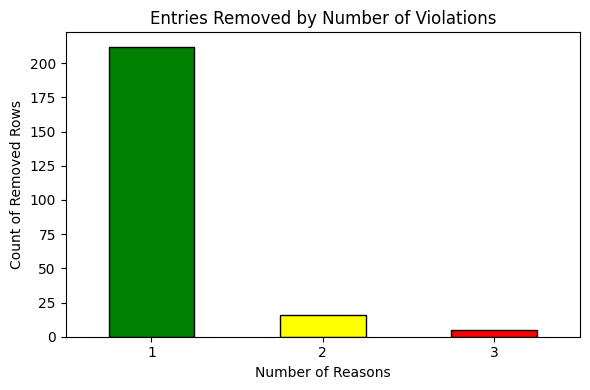


====== Removal Summary Table ======
                            Reason  Count
  TotalTimeExperiment < 300,000 ms    148
             KlickenSieDie4An != 4     49
TotalTimeExperiment > 3,600,000 ms     27
                          Age < 18     20
             Deutschkenntnisse > 4     11
          MatrikelNummer == 'Test'      4


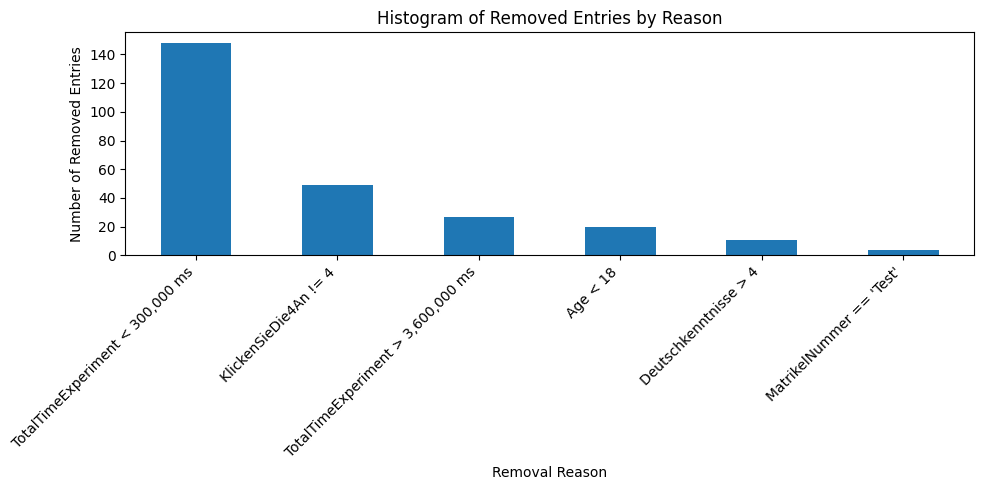

Rows before: 1831  |  removed: 233  |  kept: 1598
                                                                      source_file                                                                    RemovalReasons                MatrikelNummer       Age  TotalTimeExperiment  DeutschkenntnisseGutSchlecht  KlickenSieDie4An
                       20250828_153410_Survey_23_Warenkorb_NeutralM_LA-11I29G.csv                                                   KlickenSieDie4An != 4; Age < 18                             0 16.000000               613482                             1                 3
                       20250829_112002_Survey_23_Warenkorb_NeutralM_DL-YAJSKU.csv                                                  TotalTimeExperiment < 300,000 ms                             0 26.000000               271692                             1                 4
                      20250829_163547_Survey_28_Mall_Donation_Money_LA-A5AQ6Z.csv                                                  

In [ ]:

df = pd.read_csv("Merging/Results/Merged_1_sorted.csv", engine="python")
ouput_path = "Merging/Results/Merged_2_filtered.csv"


if "Age" in df:
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")   # non-numeric → NaN
    df["Age"] = df["Age"].fillna(df["Age"].mean())          # fill NaN with mean



# --- build rule masks (one boolean Series per rule) ---
m_matrikel_test = df["MatrikelNummer"].astype(str).str.strip().str.lower().eq("test") if "MatrikelNummer" in df else False
m_click_fail = (df["KlickenSieDie4An"] != 4) if "KlickenSieDie4An" in df else False
m_time_too_long = (df["TotalTimeExperiment"] > 18_000_000) if "TotalTimeExperiment" in df else False   # > 30 min
m_time_too_short = (df["TotalTimeExperiment"] < 300_000) if "TotalTimeExperiment" in df else False     # < 5 min
m_de_lang_low = (df["DeutschkenntnisseGutSchlecht"] > 4) if "DeutschkenntnisseGutSchlecht" in df else False
m_age_too_young = (df["Age"] < 18) if "Age" in df else False

print(len(m_age_too_young))


# --- pack masks with human-readable reasons ---
mask_table = pd.DataFrame({
    "MatrikelNummer == 'Test'": m_matrikel_test,
    "KlickenSieDie4An != 4": m_click_fail,
    "Age < 18": m_age_too_young,
    "TotalTimeExperiment > 3,600,000 ms": m_time_too_long,
    "TotalTimeExperiment < 300,000 ms": m_time_too_short,
    "Deutschkenntnisse > 4": m_de_lang_low,
})

# rows to remove = any rule true
to_remove_mask = mask_table.any(axis=1)

removed = df.loc[to_remove_mask].copy()
kept    = df.loc[~to_remove_mask].copy()

# attach a semicolon-joined reason list per removed row
def join_reasons(row_bool):
    return "; ".join(mask_table.columns[row_bool.values])

removed["RemovalReasons"] = mask_table.loc[removed.index].apply(join_reasons, axis=1)

removed["ReasonCount"] = removed["RemovalReasons"].str.split(";").apply(len)



reason_group_counts = removed["ReasonCount"].map(
    lambda x: x if x < int(3) else 3
).value_counts().sort_index()

color_map = {
    1: "green",
    2: "yellow",
    3: "red"
}
bar_colors = [color_map[i] for i in reason_group_counts.index]


plt.figure(figsize=(6,4))
reason_group_counts.plot(
    kind="bar",
    color=bar_colors,
    edgecolor="black"
)

plt.title("Entries Removed by Number of Violations")
plt.xlabel("Number of Reasons")
plt.ylabel("Count of Removed Rows")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

reason_counts = mask_table.loc[removed.index].sum().sort_values(ascending=False)

print("\n====== Removal Summary Table ======")
print(reason_counts.reset_index().rename(columns={"index": "Reason", 0: "Count"}).to_string(index=False))


# --- create histogram / bar chart ---
plt.figure(figsize=(10, 5))
reason_counts.plot(kind="bar")
plt.xlabel("Removal Reason")
plt.ylabel("Number of Removed Entries")
plt.title("Histogram of Removed Entries by Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- print a concise report ---
print(f"Rows before: {len(df)}  |  removed: {len(removed)}  |  kept: {len(kept)}")
cols_preview = [c for c in [
    "source_file","RemovalReasons","MatrikelNummer","Age",
    "TotalTimeExperiment","DeutschkenntnisseGutSchlecht","KlickenSieDie4An",
    
] if c in removed.columns]
if len(removed) > 0:
    # prints all removed rows; if this is too long, use head()
    print(removed[cols_preview].to_string(index=False))

#außreißer für total spent entfernen


# --- save results ---
#removed.to_csv("Merging/Results/Merged_removed.csv", index=False)
kept.to_csv(ouput_path, index=False)

### Additional Filtering of the data set per Experiment Time

In [ ]:
#!/usr/bin/env python

import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


INPUT_PATH = Path("Merging/Results/Merged_2_filtered.csv")
OUTPUT_DIR = Path("Analysis")
OUTPUT_CSV = OUTPUT_DIR / "Experiment_Time_Distribution.csv"
OUTPUT_PNG = OUTPUT_DIR / "Experiment_Time_Distribution.png"


def main() -> None:
    # Load data
    df = pd.read_csv(INPUT_PATH)

    if "TotalTimeExperiment" not in df.columns or "Experiment_Type" not in df.columns:
        raise ValueError("Required columns missing: 'TotalTimeExperiment' or 'Experiment_Type'")

    # Convert ms → minutes
    df["ExperimentTime_min"] = df["TotalTimeExperiment"] / 60000.0

    # Overall mean experiment time (in minutes)
    overall_mean_min = df["ExperimentTime_min"].mean()
    print(f"Overall mean experiment time: {overall_mean_min:.2f} minutes")

    # Mean per experiment type
    summary = (
        df.groupby("Experiment_Type")["ExperimentTime_min"]
          .mean()
          .reset_index()
          .rename(columns={"ExperimentTime_min": "Mean_ExperimentTime_min"})
    )

    # Ensure output directory exists
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    # Save summary table
    summary.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved summary CSV to {OUTPUT_CSV}")

    # Barplot of mean experiment time by experiment type
    plt.figure(figsize=(10, 5))
    plt.bar(summary["Experiment_Type"], summary["Mean_ExperimentTime_min"])
    plt.xlabel("Experiment Type")
    plt.ylabel("Average Experiment Time (min)")
    plt.title("Experiment Time Distribution by Experiment Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(OUTPUT_PNG)
    plt.close()
    print(f"Saved barplot PNG to {OUTPUT_PNG}")

    box_quantiles = (
    df.groupby("Experiment_Type")["ExperimentTime_min"]
      .quantile([0.0, 0.25, 0.5, 0.75, 1.0])
      .unstack()
)
box_quantiles.columns = ["min", "q1", "median", "q3", "max"]
boxplot_data = box_quantiles.reset_index()
boxplot_data.to_csv(OUTPUT_DIR / "Experiment_Time_Boxplot_Data.csv", index=False)



if __name__ == "__main__":
    main()


Overall mean experiment time: 16.02 minutes
Saved summary CSV to Analysis/Experiment_Time_Distribution.csv
Saved barplot PNG to Analysis/Experiment_Time_Distribution.png


### Calculate Scales


In [256]:
INPUT_PATH = "Merging/Results/Merged_2_filtered.csv"
OUTPUT_PATH = "Merging/Results/Merged_3_scales_merged.csv"

# === Scale groups ===
SCALE_GROUPS = {
    "Social_Status_Old_1_4": [
        "Scale_SocialStatus_1","Scale_SocialStatus_2","Scale_SocialStatus_3","Scale_SocialStatus_4",
    ],
    "Social_Status_New_1_7": [
        "Scale_SocialStatus_1","Scale_SocialStatus_2","Scale_SocialStatus_3",
        "Scale_SocialStatus_4","Scale_SocialStatus_5","Scale_SocialStatus_6","Scale_SocialStatus_7",
    ],
    "Environmental_Concern": [
        "Scale_EnvironmentalConcern_1","Scale_EnvironmentalConcern_2",
        "Scale_EnvironmentalConcern_3","Scale_EnvironmentalConcern_4",
    ],
    "Materialism": [
        "Scale_Materialism_1","Scale_Materialism_2","Scale_Materialism_3","Scale_Materialism_4",
    ],
    "Green_Values": [
        "Scale_GreenValueScale_1","Scale_GreenValueScale_2","Scale_GreenValueScale_3",
        "Scale_GreenValueScale_4","Scale_GreenValueScale_5","Scale_GreenValueScale_6",
    ],
    "Social_Confidence": [
        "Scale_SocialConfidence_1","Scale_SocialConfidence_2","Scale_SocialConfidence_3",
        "Scale_SocialConfidence_4","Scale_SocialConfidence_5",
    ],
    "Need_for_Differentiation": [
        "Scale_Differentiation_1","Scale_Differentiation_2","Scale_Differentiation_3",
    ],
    "Altruism": [
        "Scale_Altruism_1","Scale_Altruism_2","Scale_Altruism_3","Scale_Altruism_4",
    ],
    "Empathy": [
        "Scale_Empathy_1","Scale_Empathy_2","Scale_Empathy_3","Scale_Empathy_4",
    ],
    "Egoism": [
        "Scale_Egoism_1","Scale_Egoism_2","Scale_Egoism_3",
        "Scale_Egoism_4","Scale_Egoism_5","Scale_Egoism_6",
    ],
}

# === Load ===
df = pd.read_csv(INPUT_PATH, sep=None, engine="python", dtype=str)
df.columns = [c.strip() for c in df.columns]

# === Helper: numeric conversion ===
def coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            s = df[c].astype(str).str.strip().replace({"": None, "na": None, "NA": None})
            s = s.str.replace(",", ".", regex=False)
            df[c] = pd.to_numeric(s, errors="coerce")

# === Compute and add new mean columns ===
used_cols = set()
new_cols = []

for new_col, cols in SCALE_GROUPS.items():
    present = [c for c in cols if c in df.columns]
    if not present:
        print(f"⚠️ {new_col}: no matching items found")
        df[new_col] = pd.NA
        new_cols.append(new_col)
        continue

    coerce_numeric(df, present)
    df[new_col] = df[present].mean(axis=1, skipna=True).round(2)
    used_cols.update(present)
    new_cols.append(new_col)
    print(f"✅ {new_col}: used {len(present)}/{len(cols)} items")

# === Drop all used item columns ===
df.drop(columns=list(used_cols), inplace=True, errors="ignore")

# === Insert new columns after FreundlichUnfreundlich ===
if "FreundlichUnfreundlich" in df.columns:
    insert_pos = df.columns.get_loc("FreundlichUnfreundlich") + 1
else:
    insert_pos = len(df.columns)
    print("⚠️ 'FreundlichUnfreundlich' not found, appending new scales at the end.")

# Rebuild DataFrame with new column order
cols_before = list(df.columns[:insert_pos])
cols_after = list(df.columns[insert_pos:])
ordered_cols = cols_before + new_cols + cols_after
df = df.reindex(columns=ordered_cols)

# === Save ===
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"\nNew CSV created: {OUTPUT_PATH}")
print(f" Dropped {len(used_cols)} used item columns")
print(f" Inserted new scale columns after 'FreundlichUnfreundlich'")

✅ Social_Status_Old_1_4: used 4/4 items
✅ Social_Status_New_1_7: used 7/7 items
✅ Environmental_Concern: used 4/4 items
✅ Materialism: used 4/4 items
✅ Green_Values: used 6/6 items
✅ Social_Confidence: used 5/5 items
✅ Need_for_Differentiation: used 3/3 items
✅ Altruism: used 4/4 items
✅ Empathy: used 4/4 items
✅ Egoism: used 6/6 items

New CSV created: Merging/Results/Merged_3_scales_merged.csv
 Dropped 43 used item columns
 Inserted new scale columns after 'FreundlichUnfreundlich'


In [257]:
import pandas as pd

# Read input
df = pd.read_csv("Merging/Results/Merged_3_scales_merged.csv", engine="python")
output = "Merging/Results/Merged_4_outliersRemoved.csv"

print("=== INITIAL DATA ===")
print(f"Total rows before filtering: {len(df):,}")
print(df["totalSpent"].describe())

# Option 1: Use 3×IQR (instead of 1.5×IQR)
Q1 = df["totalSpent"].quantile(0.25)
Q3 = df["totalSpent"].quantile(0.75)
IQR = Q3 - Q1

upper = df["totalSpent"].quantile(0.995)  # top 0.5%
print(f"99.5th percentile cutoff: {upper:.2f}")

master_no_high_outliers = df[(df["totalSpent"].isna()) | (df["totalSpent"] <= upper)]


print("\n=== AFTER REMOVAL ===")
print(f"Remaining rows: {len(master_no_high_outliers):,}")
print(f"Rows removed: {len(df) - len(master_no_high_outliers):,}")
print(f"Percentage removed: {(1 - len(master_no_high_outliers) / len(df)) * 100:.2f}%")

print("\nNew 'totalSpent' summary after filtering:")
print(master_no_high_outliers["totalSpent"].describe())

# Save to CSV
master_no_high_outliers.to_csv(output, index=False)


=== INITIAL DATA ===
Total rows before filtering: 1,598
count       704.000000
mean        686.946776
std        8937.286877
min           0.000000
25%          56.832500
50%         168.230000
75%         419.892500
max      236384.780000
Name: totalSpent, dtype: float64
99.5th percentile cutoff: 7375.38

=== AFTER REMOVAL ===
Remaining rows: 1,594
Rows removed: 4
Percentage removed: 0.25%

New 'totalSpent' summary after filtering:
count     700.000000
mean      309.673886
std       533.929459
min         0.000000
25%        56.457500
50%       165.660000
75%       398.025000
max      7226.180000
Name: totalSpent, dtype: float64


### add DV Column

## Grouping by Experiment and Sorting Master File

In [258]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Splits one big merged CSV (Results/Merged_cleaned_filtered.csv)
into separate folders by Experiment_Type under ./Results/Per_Experiment/
and then builds a master file in the correct experiment order.
"""

import os
from typing import List, Dict
import pandas as pd

# =========================================================
# === CONFIGURATION =======================================
# =========================================================
INPUT_FILE = "Merging/Results/Merged_4_outliersRemoved.csv"
OUTPUT_ROOT = "Merging/Results"
PER_EXPERIMENT_DIR = os.path.join(OUTPUT_ROOT, "Per_Experiment")

# Fixed experiment order
EXPERIMENT_ORDER: List[str] = [
    "BB_T_D_M", "BB_T_D_T", "BB_T_D_SM", "BB_T_D_ST",
    "M_D_M", "M_D_T", "M_D_A_M", "M_D_A_T", "M_D_N_M", "M_D_N_T", "M_D_S_M", "M_D_S_T",
    "M_T_A", "M_T_N", "M_T_NV",
    "W_G", "W_H", "W_N", "W_NV_G", "W_NV_N",
    "W_VA_H", "W_VA_N", "W_VN_H", "W_VN_N",
    "W_V_G", "W_V_N", "W_GHE", "W_HGE",
]


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def read_csv_robust(path: str) -> pd.DataFrame:
    """Read CSV robustly (utf-8 or latin-1)."""
    for enc in ("utf-8", "latin-1"):
        try:
            return pd.read_csv(path, engine="python", encoding=enc)
        except Exception:
            continue
    raise RuntimeError(f"[ERROR] Cannot read CSV: {path}")


def parse_experiment_code_from_name(name: str) -> str:
    """Infer experiment code from file name if not given."""
    low = name.lower()
    # BeachBar
    if "beachbar" in low:
        spend = "S" if "spendentafel" in low else None
        meas = "M" if "money" in low else ("T" if "time" in low else None)
        if spend and meas:
            return f"BB_T_D_{spend}{meas}"
        if meas:
            return f"BB_T_D_{meas}"
        return "BB_T_D"

    # Mall
    if "mall" in low:
        if "donation" in low:
            cond = "S" if "spendentafel" in low else ("A" if "awe" in low else ("N" if "neutral" in low else None))
            meas = "M" if "money" in low else ("T" if "time" in low else None)
            if cond and meas:
                return f"M_D_{cond}_{meas}"
            if meas:
                return f"M_D_{meas}"
            if cond:
                return f"M_D_{cond}"
            return "M_D"
        if "trash" in low:
            if "novideo" in low:
                return "M_T_NV"
            if "awe" in low:
                return "M_T_A"
            if "neutral" in low:
                return "M_T_N"
            return "M_T"
        return "M_UNKNOWN"

    # Warenkorb
    if "warenkorb" in low:
        if "glamhippiee" in low:
            return "W_GHE"
        if "hippieglame" in low:
            return "W_HGE"

        vip = "V" if ("vip" in low and "nonvip" not in low and "non_vip" not in low) else (
            "NV" if ("nonvip" in low or "non_vip" in low or "_nv" in low) else None)
        video = "VA" if ("videoawe" in low or "_va_" in low) else (
            "VN" if ("videoneutral" in low or "_vn_" in low) else None)
        style = "G" if "glam" in low else ("H" if "hippie" in low else ("N" if "neutral" in low else None))
        if video and style:
            return f"W_{video}_{style}"
        if vip and style:
            return f"W_{vip}_{style}"
        if style:
            return f"W_{style}"
        return "W_UNKNOWN"

    return "UNKNOWN"


# =========================================================
# === CORE FUNCTIONS ======================================
# =========================================================

def split_by_experiment_from_file(master_csv: str, per_root: str) -> Dict[str, str]:
    """Split master CSV into one file per Experiment_Type under ./Results/Per_Experiment/."""
    df = read_csv_robust(master_csv)
    ensure_dir(per_root)

    # Derive Experiment_Type if missing
    if "Experiment_Type" not in df.columns:
        if "source_file" in df.columns:
            df = df.copy()
            df["Experiment_Type"] = df["source_file"].map(parse_experiment_code_from_name)
        else:
            df["Experiment_Type"] = "UNKNOWN"

    if "source_file" not in df.columns:
        df["source_file"] = os.path.basename(master_csv)

    written: Dict[str, str] = {}

    # Write each experiment separately
    for code in EXPERIMENT_ORDER:
        sub = df[df["Experiment_Type"] == code]
        out_dir = os.path.join(per_root, code)
        ensure_dir(out_dir)
        out_csv = os.path.join(out_dir, "merged.csv")
        sub.to_csv(out_csv, index=False, encoding="utf-8")
        written[code] = out_csv
        print(f"[OK] {code:10s} → {len(sub)} rows")

    # Handle remaining experiments (not in order list)
    others = df[~df["Experiment_Type"].isin(EXPERIMENT_ORDER)]
    if len(others) > 0:
        out_dir = os.path.join(per_root, "OTHER")
        ensure_dir(out_dir)
        out_csv = os.path.join(out_dir, "merged.csv")
        others.to_csv(out_csv, index=False, encoding="utf-8")
        written["OTHER"] = out_csv
        print(f"[OK] OTHER       → {len(others)} rows")

    return written


def build_master(per_root: str, out_root: str) -> str:
    """Concatenate all per-experiment merged CSVs in your desired order."""
    parts: List[pd.DataFrame] = []
    for code in EXPERIMENT_ORDER:
        p = os.path.join(per_root, code, "merged.csv")
        if os.path.isfile(p):
            parts.append(pd.read_csv(p, engine="python"))
    other_p = os.path.join(per_root, "OTHER", "merged.csv")
    if os.path.isfile(other_p):
        parts.append(pd.read_csv(other_p, engine="python"))

    master = pd.concat(parts, axis=0, sort=False, ignore_index=True) if parts else pd.DataFrame()
    ensure_dir(out_root)
    out_csv = os.path.join(out_root, "master_final.csv")
    master.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"[DONE] Master sorted → {out_csv} ({len(master)} rows, {len(master.columns)} columns)")
    return out_csv


# =========================================================
# === MAIN EXECUTION ======================================
# =========================================================

if __name__ == "__main__":
    print(f"[INFO] Reading input file: {INPUT_FILE}")
    split_by_experiment_from_file(INPUT_FILE, PER_EXPERIMENT_DIR)
    build_master(PER_EXPERIMENT_DIR, OUTPUT_ROOT)


[INFO] Reading input file: Merging/Results/Merged_4_outliersRemoved.csv
[OK] BB_T_D_M   → 88 rows
[OK] BB_T_D_T   → 60 rows
[OK] BB_T_D_SM  → 61 rows
[OK] BB_T_D_ST  → 63 rows
[OK] M_D_M      → 62 rows
[OK] M_D_T      → 54 rows
[OK] M_D_A_M    → 50 rows
[OK] M_D_A_T    → 58 rows
[OK] M_D_N_M    → 55 rows
[OK] M_D_N_T    → 58 rows
[OK] M_D_S_M    → 60 rows
[OK] M_D_S_T    → 69 rows
[OK] M_T_A      → 54 rows
[OK] M_T_N      → 46 rows
[OK] M_T_NV     → 56 rows
[OK] W_G        → 54 rows
[OK] W_H        → 58 rows
[OK] W_N        → 45 rows
[OK] W_NV_G     → 65 rows
[OK] W_NV_N     → 51 rows
[OK] W_VA_H     → 62 rows
[OK] W_VA_N     → 52 rows
[OK] W_VN_H     → 51 rows
[OK] W_VN_N     → 59 rows
[OK] W_V_G      → 51 rows
[OK] W_V_N      → 50 rows
[OK] W_GHE      → 55 rows
[OK] W_HGE      → 47 rows
[DONE] Master sorted → Merging/Results/master_final.csv (1594 rows, 148 columns)
